In [105]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

tf.__version__

'2.8.0'

In [106]:
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


In [107]:
import matplotlib.pyplot as plt # = from matplotlib import pyplot as plt
import numpy as np

import pathlib
import shutil
import tempfile

from IPython import display


In [108]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


# The Higgs dataset
The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [109]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [110]:
FEATURES = 28

The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [111]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [112]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1) # stack can put together arrays and flip them based on chosen axis
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new tf.data.Dataset that takes batches of 10,000 examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [113]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()


In [114]:
# map function performs specified action for every item in the inputed array
# example for my info:
dataset = tf.data.Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
dataset = dataset.map(lambda x: x ** 2)
list(dataset.as_numpy_iterator())

[1, 4, 9, 16, 25]

Inspect some of the records from this new packed_ds.

The features are not perfectly normalized, but this is sufficient for this tutorial.

Features[0]:
tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)

Number of features:
1000

Label[:10]:
tf.Tensor([1. 1. 1. 0. 1. 0. 1. 1. 1. 1.], shape=(10,), dtype=float32)

Number of labels:
1000



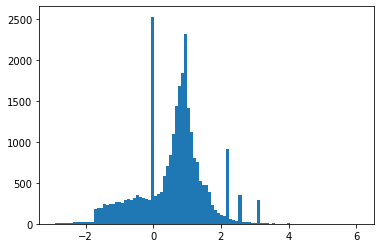

In [115]:
for features, label in packed_ds.batch(1000).take(1): # take() "Creates a Dataset with at most count elements from this dataset."
  print("Features[0]:", features[0], sep="\n", end="\n"*2)
  print("Number of features:", len(features), sep="\n", end="\n"*2)
  print("Label[:10]:", label[:10], sep="\n", end="\n"*2)
  print("Number of labels:", len(label), sep="\n", end="\n"*2)
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short, use just the first 1,000 samples for validation, and the next 10,000 for training:

In [116]:
# 1e3 means 1 x 10**-3
# example float(1e-3)==(1*10**-3) -> True

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [117]:
print(
  f"N_VALIDATION: {N_VALIDATION}",
  f"N_TRAIN: {N_TRAIN}",
  f"BUFFER_SIZE: {BUFFER_SIZE}",
  f"BATCH_SIZE: {BATCH_SIZE}",
  f"STEPS_PER_EPOCH: {STEPS_PER_EPOCH}",
  sep="\n"
  )



N_VALIDATION: 1000
N_TRAIN: 10000
BUFFER_SIZE: 10000
BATCH_SIZE: 500
STEPS_PER_EPOCH: 20


The Dataset.skip and Dataset.take methods make this easy.

At the same time, use the Dataset.cache method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [118]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
print("Lenght of dataset:", len(list(validate_ds.as_numpy_iterator())), end="\n"*2)

# seems that the same data are returned via slicing and via take
# notice that the validate_ds as "dataset" has really arrays with features and labels together, separated by comma.
print(list(validate_ds.as_numpy_iterator())[:2], end="\n"*2)
print(list(validate_ds.take(1)))

Lenght of dataset: 1000

[(array([ 0.8692932 , -0.6350818 ,  0.22569026,  0.32747006, -0.6899932 ,
        0.75420225, -0.24857314, -1.0920639 ,  0.        ,  1.3749921 ,
       -0.6536742 ,  0.9303491 ,  1.1074361 ,  1.1389043 , -1.5781983 ,
       -1.0469854 ,  0.        ,  0.65792954, -0.01045457, -0.04576717,
        3.1019614 ,  1.35376   ,  0.9795631 ,  0.97807616,  0.92000484,
        0.72165745,  0.98875093,  0.87667835], dtype=float32), 1.0), (array([ 9.0754211e-01,  3.2914728e-01,  3.5941187e-01,  1.4979699e+00,
       -3.1300953e-01,  1.0955306e+00, -5.5752492e-01, -1.5882298e+00,
        2.1730762e+00,  8.1258118e-01, -2.1364193e-01,  1.2710146e+00,
        2.2148721e+00,  4.9999395e-01, -1.2614318e+00,  7.3215616e-01,
        0.0000000e+00,  3.9870089e-01, -1.1389301e+00, -8.1911020e-04,
        0.0000000e+00,  3.0221990e-01,  8.3304816e-01,  9.8569965e-01,
        9.7809839e-01,  7.7973217e-01,  9.9235576e-01,  7.9834259e-01],
      dtype=float32), 1.0)]

[(<tf.Tensor: sh

In [119]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the Dataset.batch method to create batches of an appropriate size for training. Before batching, also remember to use Dataset.shuffle and Dataset.repeat on the training set.

In [120]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### Demonstrate overfitting
The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only densely-connected layers (tf.keras.layers.Dense) as a baseline, then create larger models, and compare them.

### Training procedure
Many models train better if you gradually reduce the learning rate during training. Use tf.keras.optimizers.schedules to reduce the learning rate over time:

In [121]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False,
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Step
[     0.           2040.81632653   4081.63265306   6122.44897959
   8163.26530612  10204.08163265  12244.89795918  14285.71428571
  16326.53061224  18367.34693878  20408.16326531  22448.97959184
  24489.79591837  26530.6122449   28571.42857143  30612.24489796
  32653.06122449  34693.87755102  36734.69387755  38775.51020408
  40816.32653061  42857.14285714  44897.95918367  46938.7755102
  48979.59183673  51020.40816327  53061.2244898   55102.04081633
  57142.85714286  59183.67346939  61224.48979592  63265.30612245
  65306.12244898  67346.93877551  69387.75510204  71428.57142857
  73469.3877551   75510.20408163  77551.02040816  79591.83673469
  81632.65306122  83673.46938776  85714.28571429  87755.10204082
  89795.91836735  91836.73469388  93877.55102041  95918.36734694
  97959.18367347 100000.        ]

learning rate
tf.Tensor(
[0.001      0.00090741 0.00083051 0.00076563 0.00071014 0.00066216
 0.00062025 0.00058333 0.00055056 0.00052128 0.00049495 0.00047115
 0.00044954 0.00042982

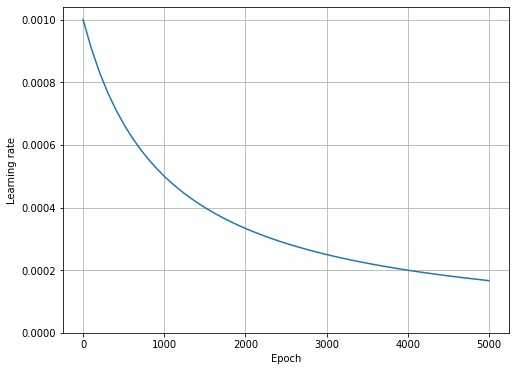

In [122]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())]) # tohle by mělo upravit max limit y, ale tady to nic nedělá
plt.xlabel("Epoch")
_ = plt.ylabel("Learning rate")
plt.grid()

print("Step", step, sep="\n", end="\n"*2 )
print("learning rate", lr_schedule(step), sep="\n", end="\n"*2)
print("step/STEPS_PER_EPOCH (Epochs)", step/STEPS_PER_EPOCH, sep="\n", end="\n"*2)

Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply prints a "." for each epoch, and a full set of metrics every 100 epochs.

Next include tf.keras.callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.

Use callbacks.TensorBoard to generate TensorBoard logs for the training.

In [123]:
def get_callbacks(name):
  return[
         tfdocs.modeling.EpochDots(),
         tf.keras.callbacks.EarlyStopping(monitor="val_binary_crossentropy", patience=200),
         tf.keras.callbacks.TensorBoard(logdir/name)
  ]

Similarly each model will use the same Model.compile and Model.fit settings:

In [138]:
  def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
      optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name="binary_crossentropy"), "accuracy"]
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )
    return history

### Tiny model

In [125]:
tiny_model = tf.keras.Sequential([
                                  tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES, )),
                                  tf.keras.layers.Dense(1)
])

size_histories = {}

size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                464       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4913,  binary_crossentropy:0.7449,  loss:0.7449,  val_accuracy:0.4650,  val_binary_crossentropy:0.7381,  val_loss:0.7381,  
....................................................................................................
Epoch: 100, accuracy:0.6012,  binary_crossentropy:0.6237,  loss:0.6237,  val_accuracy:0.5950,  val_binary_crossentropy:0.6263,  val_loss:0.6263,  
..........................................................

check how the model did

Text(0.5, 0, 'Epochs [Log Scale]')

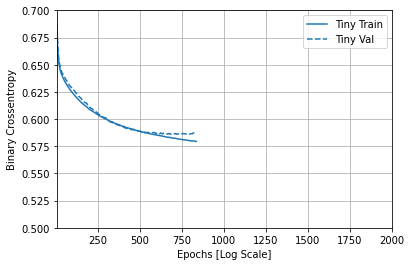

In [137]:
plotter = tfdocs.plots.HistoryPlotter(metric="binary_crossentropy", smoothing_std=10)
plotter.plot(size_histories)
#plt.xscale('log')
plt.xlim([5, 2000])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")


### Small model
To check if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [145]:
# missing comma on purpouse behind features
small_model = tf.keras.Sequential([
                                   tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
                                   tf.keras.layers.Dense(16, activation="elu"),
                                   tf.keras.layers.Dense(1)
])

size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                464       
                                                                 
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4758,  binary_crossentropy:0.7659,  loss:0.7659,  val_accuracy:0.4660,  val_binary_crossentropy:0.7340,  val_loss:0.7340,  
....................................................................................................
Epoch: 100, accuracy:0.6400,  binary_crossentropy:0.6040,  loss:0.6040,  

### Medium model
Now try three hidden layers with 64 units each:

In [140]:
medium_model = tf.keras.Sequential([
                                    tf.keras.layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
                                    tf.keras.layers.Dense(64, activation="elu"),
                                    tf.keras.layers.Dense(64, activation="elu"),
                                    layers.Dense(1)
])



And train the model using the same data:

In [141]:
size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                1856      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4912,  binary_crossentropy:0.6891,  loss:0.6891,  val_accuracy:0.5210,  val_binary_crossentropy:0.6703,  val_loss:0.6703,  
....................................

###Large model
As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [142]:
large_model = tf.keras.Sequential([
                                   layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
                                   layers.Dense(512, activation="elu"),
                                   layers.Dense(512, activation="elu"),
                                   layers.Dense(512, activation="elu"),
                                   layers.Dense(1)
])


And, again, train the model using the same data:

In [143]:
size_histories["Large model"] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 512)               14848     
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5086,  binary_crossentropy

###Plot the training and validation losses
The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the "Tiny" model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the "large" model that you need to switch the plot to a log-scale to really figure out what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
-If both metrics are moving in the same direction, everything is fine.
-If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
-If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

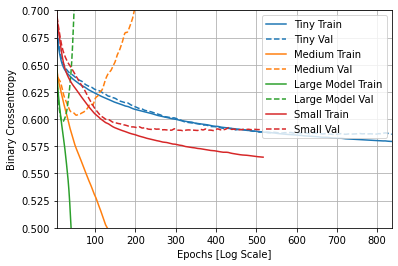

In [153]:
plotter.plot(size_histories)
#a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Underfitting, picture on the left side, the error on both of those lines is high.
Underfittin, picture on the right side, the curves should be closer, perhaps the model needs some more tweaking or train longer.

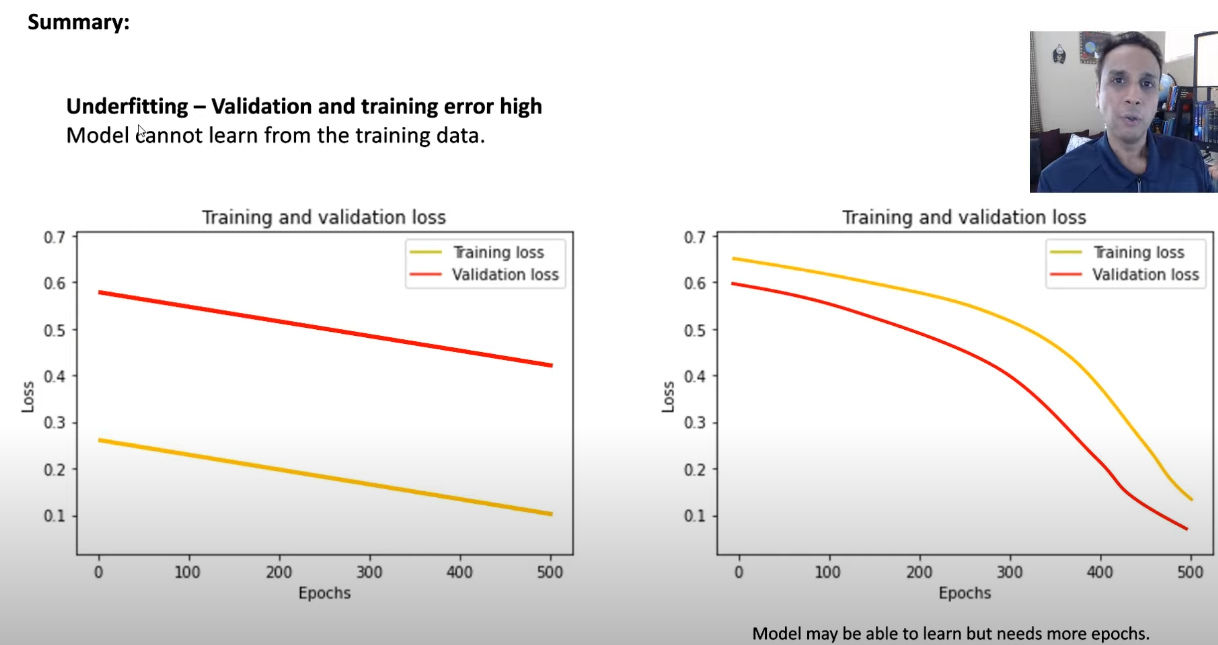

Overfitting, picture on the left side. The training curve is lower and validation is higher, meaning the model learned training data and does not generalize.

Dropout, can be used to boost performance. In that case the validation curve can be lower, because values at training set were in some ratio (20-50% 0,2-0,5) made to 0. This means that the validation set will be more robust and the validation curve can be lower = ok.

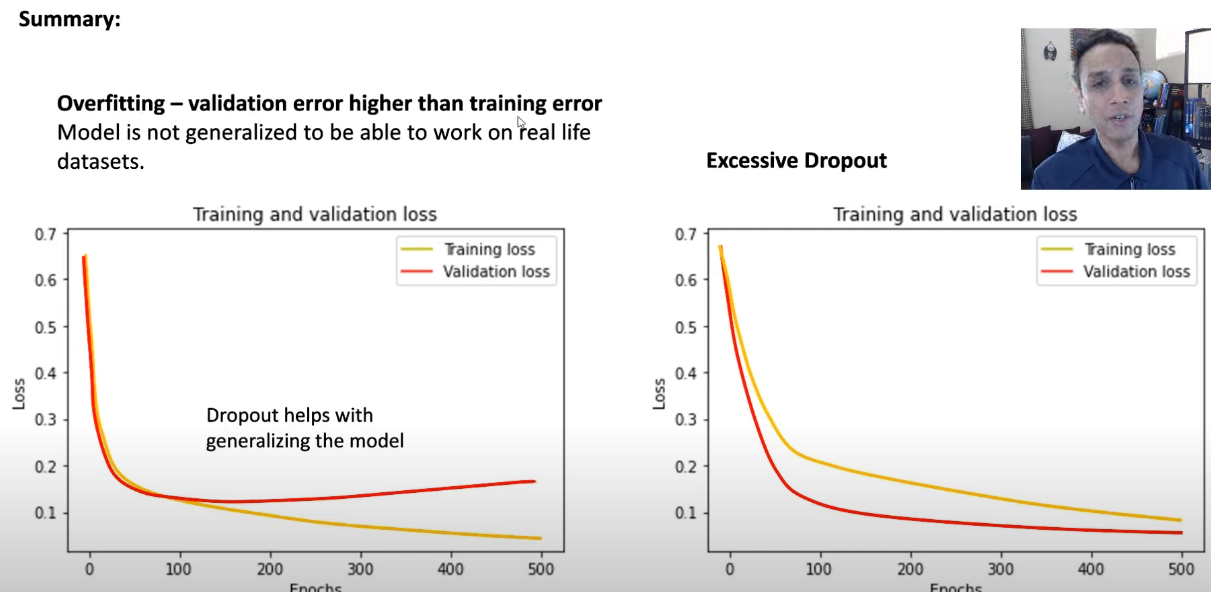

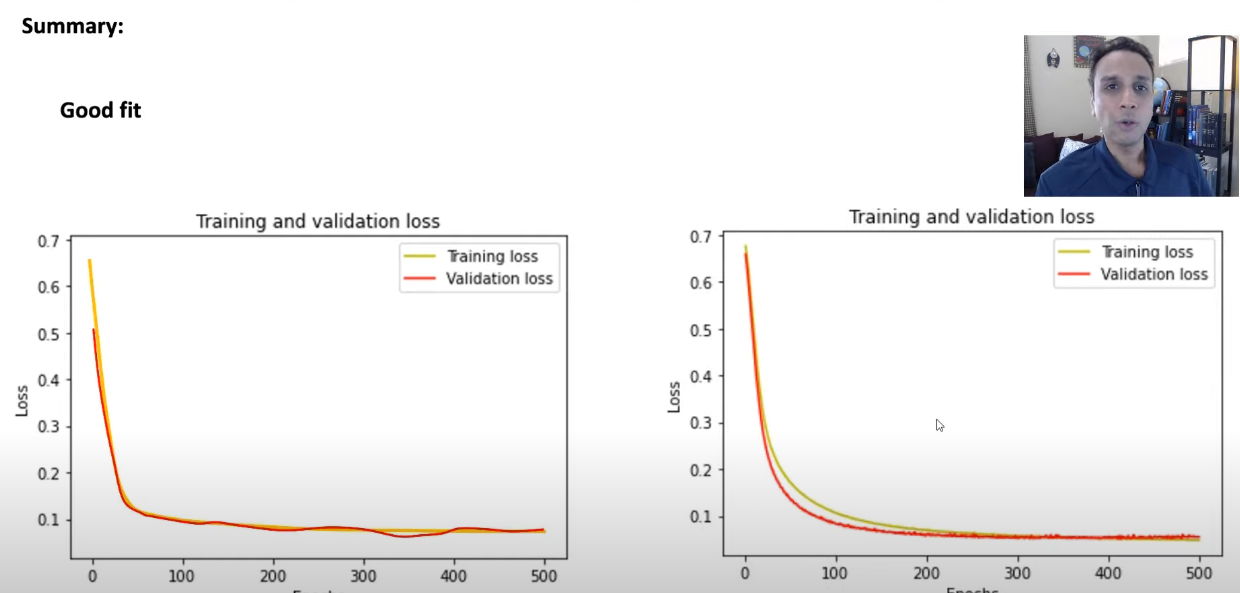